## Imports

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import (
    color, feature, filters, measure, morphology, segmentation, util, exposure, data, io
)
from skimage import io
import cv2
import random
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
from cellpose import models
import time
from collections import defaultdict
import numpy as np
import tifffile as tif
from scipy import ndimage, signal
import math

%matplotlib inline
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

## Load Images

### Segmented

In [2]:
segmentedT = np.load('path_to_segmentedT')
segmentedTarget = np.load('path_to_segmentedTarget')
segmentedDead = np.load('path_to_segmentedDead')

### Raw

In [3]:
T_cells = np.load('path_to_T')
Target_cells = np.load('path_to_Target')
Dead_cells = np.load('path_to_Dead')

## Remove Dead T Cells

FOUND 1/28 DEAD T CELLS IN FRAME 0
FOUND 2/28 DEAD T CELLS IN FRAME 1
FOUND 2/29 DEAD T CELLS IN FRAME 2
FOUND 2/29 DEAD T CELLS IN FRAME 3
FOUND 2/29 DEAD T CELLS IN FRAME 4
FOUND 2/30 DEAD T CELLS IN FRAME 5
FOUND 1/29 DEAD T CELLS IN FRAME 6
FOUND 4/31 DEAD T CELLS IN FRAME 7
FOUND 2/31 DEAD T CELLS IN FRAME 8
FOUND 2/30 DEAD T CELLS IN FRAME 9
FOUND 2/30 DEAD T CELLS IN FRAME 10
FOUND 2/30 DEAD T CELLS IN FRAME 11
FOUND 3/31 DEAD T CELLS IN FRAME 12
FOUND 2/29 DEAD T CELLS IN FRAME 13
FOUND 2/29 DEAD T CELLS IN FRAME 14
FOUND 2/28 DEAD T CELLS IN FRAME 15
FOUND 3/29 DEAD T CELLS IN FRAME 16
FOUND 2/28 DEAD T CELLS IN FRAME 17
FOUND 3/29 DEAD T CELLS IN FRAME 18
FOUND 3/29 DEAD T CELLS IN FRAME 19
FOUND 3/30 DEAD T CELLS IN FRAME 20
FOUND 2/29 DEAD T CELLS IN FRAME 21
FOUND 2/28 DEAD T CELLS IN FRAME 22
FOUND 3/30 DEAD T CELLS IN FRAME 23
FOUND 3/29 DEAD T CELLS IN FRAME 24
FOUND 3/28 DEAD T CELLS IN FRAME 25
FOUND 2/27 DEAD T CELLS IN FRAME 26
FOUND 3/28 DEAD T CELLS IN FRAME 27
FO

FOUND 17/37 DEAD T CELLS IN FRAME 228
FOUND 18/37 DEAD T CELLS IN FRAME 229
FOUND 16/38 DEAD T CELLS IN FRAME 230
FOUND 17/39 DEAD T CELLS IN FRAME 231
FOUND 17/38 DEAD T CELLS IN FRAME 232
FOUND 16/36 DEAD T CELLS IN FRAME 233
FOUND 17/37 DEAD T CELLS IN FRAME 234
FOUND 17/37 DEAD T CELLS IN FRAME 235
FOUND 14/37 DEAD T CELLS IN FRAME 236
FOUND 15/35 DEAD T CELLS IN FRAME 237
FOUND 16/36 DEAD T CELLS IN FRAME 238
FOUND 16/36 DEAD T CELLS IN FRAME 239
FOUND 16/37 DEAD T CELLS IN FRAME 240
FOUND 13/32 DEAD T CELLS IN FRAME 241
FOUND 17/36 DEAD T CELLS IN FRAME 242
FOUND 17/38 DEAD T CELLS IN FRAME 243
FOUND 14/35 DEAD T CELLS IN FRAME 244
FOUND 17/39 DEAD T CELLS IN FRAME 245
FOUND 17/38 DEAD T CELLS IN FRAME 246
FOUND 15/37 DEAD T CELLS IN FRAME 247
FOUND 16/36 DEAD T CELLS IN FRAME 248
FOUND 14/37 DEAD T CELLS IN FRAME 249
FOUND 18/39 DEAD T CELLS IN FRAME 250
FOUND 16/37 DEAD T CELLS IN FRAME 251
FOUND 18/39 DEAD T CELLS IN FRAME 252
FOUND 20/41 DEAD T CELLS IN FRAME 253
FOUND 14/38 

FOUND 20/38 DEAD T CELLS IN FRAME 444
FOUND 21/40 DEAD T CELLS IN FRAME 445
FOUND 24/40 DEAD T CELLS IN FRAME 446
FOUND 24/41 DEAD T CELLS IN FRAME 447
FOUND 23/41 DEAD T CELLS IN FRAME 448
FOUND 24/44 DEAD T CELLS IN FRAME 449
FOUND 24/39 DEAD T CELLS IN FRAME 450
FOUND 24/42 DEAD T CELLS IN FRAME 451
FOUND 23/40 DEAD T CELLS IN FRAME 452
FOUND 24/43 DEAD T CELLS IN FRAME 453
FOUND 24/44 DEAD T CELLS IN FRAME 454
FOUND 23/43 DEAD T CELLS IN FRAME 455
FOUND 25/42 DEAD T CELLS IN FRAME 456
FOUND 30/48 DEAD T CELLS IN FRAME 457
FOUND 23/43 DEAD T CELLS IN FRAME 458
FOUND 22/38 DEAD T CELLS IN FRAME 459
FOUND 24/42 DEAD T CELLS IN FRAME 460
FOUND 25/42 DEAD T CELLS IN FRAME 461
FOUND 23/45 DEAD T CELLS IN FRAME 462
FOUND 27/44 DEAD T CELLS IN FRAME 463
FOUND 25/44 DEAD T CELLS IN FRAME 464
FOUND 29/46 DEAD T CELLS IN FRAME 465
FOUND 28/46 DEAD T CELLS IN FRAME 466
FOUND 28/46 DEAD T CELLS IN FRAME 467
FOUND 27/43 DEAD T CELLS IN FRAME 468
FOUND 27/45 DEAD T CELLS IN FRAME 469
FOUND 27/46 

Text(0, 0.5, 'Number of T cells Detected')

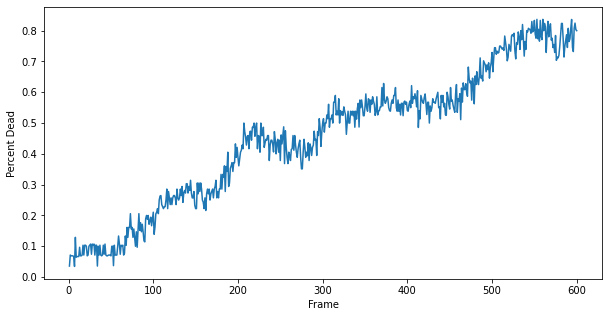

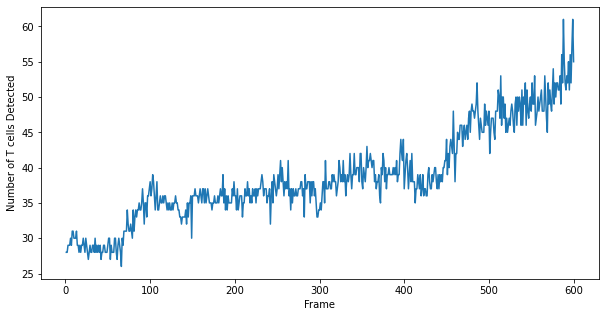

In [4]:
from skimage.metrics import structural_similarity as ssim
DOWN_SCALE = 1
numDead = []
numDetected = []
for sliceNum, masksT in enumerate(segmentedT):
    count = 0
    T_cells_frame = T_cells[sliceNum] 
    Dead_cells_frame = Dead_cells[sliceNum] 

    props = measure.regionprops(masksT, intensity_image=T_cells[sliceNum])
    diffs = []

    for p in props:
        y, x = p.centroid
        y, x = int(y), int(x)
        maskValue = masksT[y, x]
        height, width = p.intensity_image.shape
        bottom, top = max(0, int(y - 1*height)), min(masksT.shape[0], int(y + 1*height))
        left, right = max(0, int(x - 1*width)), min(masksT.shape[1], int(x + 1*width))

        T_cell_portion = T_cells_frame[bottom:top, left:right]
        Dead_cell_portion = Dead_cells_frame[bottom:top, left:right]

        try:
            temp1 = Dead_cell_portion / np.max(Dead_cell_portion)
            temp2 = masksT[bottom:top, left:right] / np.max(masksT[bottom:top, left:right])
            temp3 = T_cell_portion / np.max(T_cell_portion)
            size = np.count_nonzero(temp2)
            diff = np.sum(temp1 * temp2 - temp3) / size
            diffs.append(diff)
            if diff >= 0.25:
                count += 1
        except Exception as e:
            continue
    print(f"FOUND {count}/{len(props)} DEAD T CELLS IN FRAME {sliceNum}")
    numDead.append(count/len(props))
    numDetected.append(len(props))
    segmentedT[sliceNum] = masksT
plt.figure()
plt.plot([i + 1 for i in range(len(numDead))], numDead)
plt.xlabel('Frame')
plt.ylabel('Percent Dead')

plt.figure()
plt.plot([i + 1 for i in range(len(numDead))], numDetected)
plt.xlabel('Frame')
plt.ylabel('Number of T cells Detected')

## Load Tracking Tables

In [7]:
from bs4 import BeautifulSoup
def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1]) **2)
def xmlToDf(data, segmented, origImage):
    xml = BeautifulSoup(data, "xml")
    regions = [{} for i in range(len(segmented))]
    for i in range(len(segmented)):
        regions_frame = measure.regionprops(segmented[i], intensity_image=origImage[i])
        for r in regions_frame:
            y, x = r.centroid
            y, x = round(y, 1), round(x, 1)
            regions[i][(y, x)] = r
            
    frame, x, y, shape, regionProp, particles = [], [], [], [], [], []
    all_particles = xml.find_all('particle')
    for i, particle in enumerate(all_particles):
        detections = particle.find_all('detection')
        for detection in detections:
            frameNum = int(detection['t'])
            yC, xC = round(float(detection['y']), 1), round(float(detection['x']), 1)
            if (yC, xC) in regions[frameNum]:
                region = regions[frameNum][(yC, xC)]
            else:
                minDist, minPoint = 10**100, None
                for centroid in regions[frameNum]:
                    dist = distance(centroid, (yC, xC))
                    if dist < minDist:
                        minDist = dist
                        minPoint = centroid
                region = regions[frameNum][minPoint]

            y.append(int(round(yC, 1)))
            x.append(int(round(xC, 1)))
            shape.append(region.intensity_image.shape)
            regionProp.append(region)
            frame.append(frameNum)
            particles.append(i)
    track_df = pd.DataFrame(data = {'particle': particles, 'frame': frame, 'x': x, 'y': y, 'shape': shape, 'region': regionProp})
    return track_df

with open('path_to_Tcell_table', 'r') as f:
    data = f.read()
T_cell_tracked = xmlToDf(data, segmentedT, T_cells)

with open('path_to_Targetcell_table', 'r') as f:
    data = f.read()
Target_cell_tracked = xmlToDf(data, segmentedTarget, Target_cells)

# Detect Interactions

In [8]:
def findTouching(maskMain, maskOther, x, y, shape, dfOther, dfMain, frame, dead=False, plot=False):
    OFFSET = 2
    left, right = max(0, int(x - shape[1]) - OFFSET), min(masksMain.shape[1], int(x + shape[1]) + OFFSET)
    bottom, top = max(0, int(y - shape[0]) - OFFSET), min(masksMain.shape[0], int(y + shape[0]) + OFFSET)
    
    regionOther = maskOther[bottom:top, left:right]
    regionMain = maskMain[bottom:top, left:right]
    
    # Remove masks that aren't the mask of interest
    regionMain = (regionMain == regionMain[shape[0], shape[1]]).astype(int) * regionMain[shape[0], shape[1]]
    regionMain = regionMain.astype(np.uint16)
        
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (shape[0]//2, shape[1]//2))
    dilate = cv2.dilate(regionMain, kernel, iterations=2)

    combinedMasks = regionMain + regionOther
    
    regionsPrior = measure.regionprops(regionOther)
    regionsPost = measure.regionprops(combinedMasks)
    
    before, after = [], []
    for p in regionsPrior:
        yP, xP = p.centroid
        before.append((p.area, xP, yP))
    for d in regionsPost:
        yD, xD = d.centroid
        after.append((d.area, xD, yD))
    
    touchingParams = []
    for b in before:
        if b not in after:
            touchingParams.append(b)
    
    touchingCells = []
    for t in touchingParams:
        area, xT, yT = t
        maskValue = regionOther[int(yT), int(xT)]
        for index, row in dfOther.iterrows():
            # Find which cells are touching
            if maskOther[int(row["y"]), int(row["x"])] == maskValue:
                if not dead:
                    touchingCells.append(row["particle"])
                else:
                    if distance((int(row["y"]), int(row["x"])), (y, x)) < 4:
                        touchingCells.append(row["particle"])
    if plot and len(touchingCells) > 0:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.imshow(regionMain, cmap='gray')
        ax.set_title("Main")

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.imshow(regionOther, cmap='gray')
        ax.set_title("Other")

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.imshow(combinedMasks, cmap='gray')
        ax.set_title(f"Combined with {len(touchingCells)} touches")
    
    return touchingCells

In [10]:
T_cell_tracked = T_cell_tracked.sort_values('frame')
Target_cell_tracked = Target_cell_tracked.sort_values('frame')
tracked_dfs = [T_cell_tracked, Target_cell_tracked]
for i, df in enumerate(tracked_dfs):
    touchingCol, deadCol = [], []
    s = time.time()
    for frameNum in set(df["frame"]):
        df_frame = df[df["frame"]==frameNum]
        if i == 0:
            masksMain, masksOther = segmentedT[frameNum], segmentedTarget[frameNum]
            imM, imO, dfO = T_cells[frameNum], Target_cells[frameNum], Target_cell_tracked[Target_cell_tracked['frame']==frameNum]
        if i == 1:
            masksMain, masksOther = segmentedTarget[frameNum], segmentedT[frameNum]
            imM, imO, dfO = Target_cells[frameNum], T_cells[frameNum], T_cell_tracked[T_cell_tracked['frame']==frameNum]
        props = measure.regionprops(masksMain)
        for index, row in df_frame.iterrows():
            if row["shape"][0] == "(": # Test if tuple saved as a string
                row["shape"] = eval(row["shape"])
            y, x, shape, particle = int(row["y"]), int(row["x"]), row["shape"], int(row["particle"])
            touchingCol.append([findTouching(masksMain, masksOther, x, y, shape, dfO, df, frameNum), frameNum])
        e = time.time()
        if frameNum%100 == 0:
            print(f"FINISHED FRAME {frameNum} OF CHANNEL {i} IN {e-s} SECONDS")
    df['touching'] = touchingCol

FINISHED FRAME 0 OF CHANNEL 0 IN 0.12224364280700684 SECONDS
FINISHED FRAME 100 OF CHANNEL 0 IN 10.470090389251709 SECONDS
FINISHED FRAME 200 OF CHANNEL 0 IN 32.64194869995117 SECONDS
FINISHED FRAME 300 OF CHANNEL 0 IN 47.960893630981445 SECONDS
FINISHED FRAME 400 OF CHANNEL 0 IN 58.55827617645264 SECONDS
FINISHED FRAME 500 OF CHANNEL 0 IN 66.93178987503052 SECONDS
FINISHED FRAME 0 OF CHANNEL 1 IN 0.1410353183746338 SECONDS
FINISHED FRAME 100 OF CHANNEL 1 IN 12.349014520645142 SECONDS
FINISHED FRAME 200 OF CHANNEL 1 IN 28.799994945526123 SECONDS
FINISHED FRAME 300 OF CHANNEL 1 IN 44.5808539390564 SECONDS
FINISHED FRAME 400 OF CHANNEL 1 IN 59.59870624542236 SECONDS
FINISHED FRAME 500 OF CHANNEL 1 IN 73.6488208770752 SECONDS


# Detect Dead Target Cells

In [18]:
from skimage.metrics import structural_similarity as ssim
diffs = []
deadCol = []
deadValues= []
look_ahead = 5
threshold = 0.40
for index, row in Target_cell_tracked.iterrows():
    if index % 10000 == 0:
        print(index)
    sliceNum = int(row['frame'])
    Target_cells_frame = Target_cells[sliceNum]
    Dead_cells_frame = Dead_cells[sliceNum]
    masksTarget = segmentedTarget[sliceNum]
    
    y, x = row['y'], row['x']
    y, x = int(y), int(x)
    maskValue = masksTarget[y, x]
    height, width = row['shape']
    bottom, top = max(0, int(y - height)), min(masksTarget.shape[0], int(y + height))
    left, right = max(0, int(x - width)), min(masksTarget.shape[1], int(x + width))
    
    Target_cell_portion = Target_cells_frame[bottom:top, left:right]
    Dead_cell_portion = Dead_cells_frame[bottom:top, left:right]
    
    temp1 = Dead_cell_portion / np.max(Dead_cell_portion)
    temp2 = masksTarget[bottom:top, left:right] / np.max(masksTarget[bottom:top, left:right])
    temp3 = Target_cell_portion / np.max(Target_cell_portion)
    size = np.count_nonzero(temp2)
    diff = np.sum(temp1 * temp2 - temp3 * temp2) / size
    diffs.append(diff)
    if diff >= threshold:
        uL = (left, top) #cv2 is (x, y)
        bR = (right, bottom)
        deadCol.append(True)
    else:
        # Handle cases at the end (peer ahead look_ahead number of frames)
        if sliceNum == max(Target_cell_tracked[Target_cell_tracked['particle'] == row['particle']]['frame']):
            dead = False
            for i in range(1, look_ahead + 1):
                if sliceNum + i < len(Target_cells):
                    Target_cells_frame = Target_cells[sliceNum + i]
                    Dead_cells_frame = Dead_cells[sliceNum + i]
                    masksTarget = segmentedTarget[sliceNum + i]
                    Target_cell_portion = Target_cells_frame[bottom:top, left:right]
                    Dead_cell_portion = Dead_cells_frame[bottom:top, left:right]
                    temp1 = Dead_cell_portion / np.max(Dead_cell_portion)
                    temp2 = masksTarget[bottom:top, left:right] / np.max(masksTarget[bottom:top, left:right])
                    temp3 = Target_cell_portion / np.max(Target_cell_portion)
                    size = np.count_nonzero(temp2)
                    diff = np.sum(temp1 * temp2 - temp3 * temp2) / size
                    if diff >= threshold:
                        uL = (left, top) #cv2 is (x, y)
                        bR = (right, bottom)
                        dead = True
            deadCol.append(dead)
        else:             
            deadCol.append(False)
    deadValues.append(diff)

0


C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered 

50000


C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


40000


C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered 

60000


C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


20000


C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered 

10000
70000


C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered 

30000


C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\salbe\anaconda3\envs\ML_neutrophil\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


In [19]:
Target_cell_tracked['dead'] = deadCol
Target_cell_tracked['deadValues'] = deadValues

# Interaction GIFs

In [12]:
T_OI = 8 # ID of T cell you want to track
TARGET_OI = 136 # ID of main target cell

### Look at motion of T cell

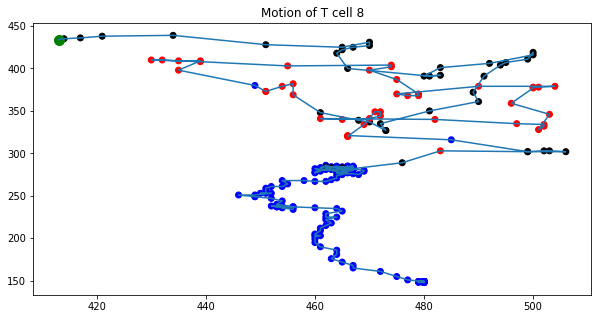

In [16]:
temp = T_cell_tracked[T_cell_tracked['particle']==T_OI]
x, y = list(temp['x']), list(temp['y'])
plt.scatter(x, y, c = ['r' if len(p[0]) > 0 and p[0][0] == TARGET_OI else 'k' if len(p[0]) > 0 else 'b' for p in temp['touching']])
plt.plot(x, y)
plt.scatter(x[:1], y[:1], s=100, c='g')
plt.title(f'Motion of T cell {T_OI}')

xlims = [max(0, min(x) - 20), min(T_cells.shape[2], max(x) + 20)]
ylims = [max(0, min(y) - 20), min(T_cells.shape[1], max(y) + 20)]

### Generate GIF

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.......

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


...............

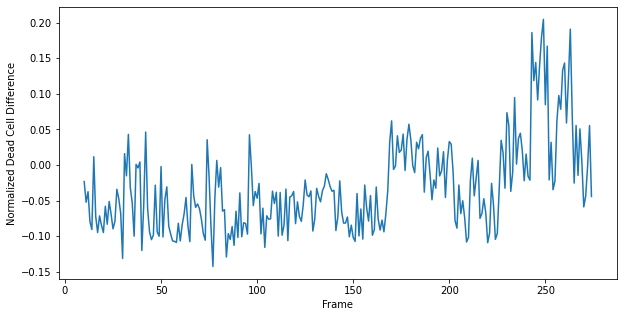

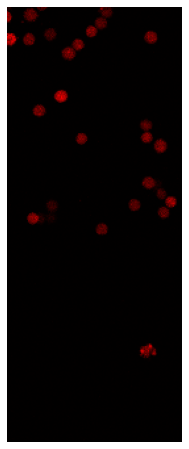

In [20]:
from matplotlib import animation
tempT = T_cell_tracked[T_cell_tracked['particle'] == T_OI]

deadLst = []
particle_df = Target_cell_tracked[Target_cell_tracked["particle"]==TARGET_OI]
for index, row in particle_df.iterrows():
    if row['dead']:
        deadLst.append(row['frame'])
        
tempTarget = Target_cell_tracked[Target_cell_tracked['particle'] == TARGET_OI]

fps = 15
snapshots = []
deadChannel = []
for index, row in tempT.iterrows():
    y, x, shape, frame, touching = row["y"], row["x"], row["shape"], row["frame"], row['touching']
    #print(frame)
    if shape[0] == "(":
        shape = eval(shape)
    #target = blank.copy()
    target = Target_cells[frame][ylims[0]:ylims[1], xlims[0]:xlims[1]]
    blank = np.zeros((target.shape))
    T = blank.copy()
    #print(shape, T.shape, y - ylims[0] - shape[0]//2, y - ylims[0] + shape[0]//2, x - xlims[0] - shape[1]//2, x - xlims[0] + shape[1]//2)
    T[y - ylims[0] - shape[0]//2: y - ylims[0] + shape[0]//2, x - xlims[0] - shape[1]//2: x - xlims[0] + shape[1]//2] = T_cells[frame][y - shape[0]//2: y + shape[0]//2, x - shape[1]//2: x + shape[1]//2]
    tempSnap = [target/np.max(target), T/np.max(T), blank.copy()]

    #if len(touching[0]) > 0 and TARGET_OI in [int(t) for t in touching[0]]:
    if len(touching[0]) > 0:
        tempSnap[0] += tempSnap[1] / np.max(tempSnap[1])
        
    #if frame in deadLst:
    if int(frame) in [int(f) for f in particle_df['frame']]:
        temp = particle_df[particle_df['frame'] == frame]
        y, x = int(temp['y']), int(temp['x'])
        maskValue = segmentedTarget[frame][y, x]
        temp = segmentedTarget[frame][:]
        temp = (temp == maskValue).astype(int)
        temp = temp[ylims[0]:ylims[1], xlims[0]:xlims[1]]
        if frame in deadLst:
            tempSnap[0] += temp/np.max(temp)/2
            tempSnap[1] += temp/np.max(temp)/2
            tempSnap[2] += temp/np.max(temp)/2
            
        else:
            tempSnap[2] += temp/np.max(temp)/2
    
    snapshots.append(np.transpose(tempSnap, (1, 2, 0)))
    deadChannel.append(Dead_cells[frame][ylims[0]:ylims[1], xlims[0]:xlims[1]])
    
for frameExtend in range(frame, min(600, frame + 100)):
    #target = blank.copy()
    target = Target_cells[frameExtend][ylims[0]:ylims[1], xlims[0]:xlims[1]]
    #T = blank.copy()
    #T[y - ylims[0] - shape[0]: y - ylims[0] + shape[0], x - xlims[0] - shape[1]: x - xlims[0] + shape[1]] = T_cells[frame][y - shape[0]: y + shape[0], x - shape[1]: x + shape[1]]
    tempSnap = [target/np.max(target), blank.copy(), blank.copy()]
    
    snapshots.append(np.transpose(tempSnap, (1, 2, 0)))
    deadChannel.append(Dead_cells[frameExtend][ylims[0]:ylims[1], xlims[0]:xlims[1]])

#nSeconds = 15
fig = plt.figure( figsize=(8,8) )
plt.axis('off')
a = snapshots[0]
im = plt.imshow(a)
def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )
    im.set_array(snapshots[i])
    return [im]

fps=15
anim = animation.FuncAnimation(
                               fig, 
                               animate_func,
                               frames = len(snapshots)
                               )
anim.save(f'T{T_OI}_Target{TARGET_OI}.gif', fps=fps, dpi=100, savefig_kwargs={'transparent': True, 'facecolor': 'none'})